In [1]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor,BaggingRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error,accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('Exxonmobil.csv')

In [3]:
data.shape 

(7551, 7)

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1994-02-28,16.34375,16.40625,16.21875,16.21875,6.277603,3781600
1,1994-03-01,16.15625,16.21875,16.09375,16.21875,6.277603,4125600
2,1994-03-02,16.15625,16.50000,16.12500,16.46875,6.374366,5707600
3,1994-03-03,16.50000,16.59375,16.43750,16.53125,6.398556,4846800
4,1994-03-04,16.50000,16.50000,16.28125,16.31250,6.313890,2743200


In [5]:
data.index 

RangeIndex(start=0, stop=7551, step=1)

In [6]:
data=data.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})

In [7]:
data=data.drop(columns=['Adj Close'],axis=1)

In [8]:
data['date']=pd.to_datetime(data['date'])

In [9]:
data.set_index('date', inplace=True)

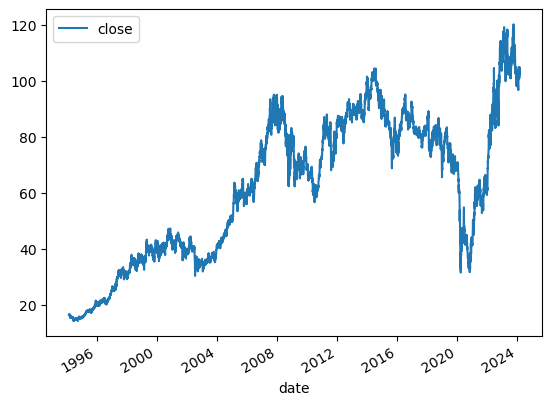

In [10]:
data.plot.line(y='close', use_index=True)
plt.savefig('Exxonmobil.png');

In [11]:
data.describe()

,open,high,low,close,volume
count,7551.000000,7551.000000,7551.000000,7551.000000,7.551000e+03
mean,61.889950,62.477638,61.304276,61.909961,1.569656e+07
std,26.030952,26.234118,25.835570,26.045079,1.016256e+07
min,14.125000,14.218750,14.031250,14.125000,1.075600e+06
25%,39.000000,39.510000,38.520000,39.000000,9.028300e+06
50%,65.660004,66.410004,65.029999,65.769997,1.300320e+07
75%,83.550003,84.229999,82.900002,83.580002,1.995640e+07
max,119.980003,120.699997,118.190002,120.199997,1.180235e+08


In [11]:
data['Tomorrow']=data['close'].shift(-1)

In [12]:
data.head() 

,open,high,low,close,volume,Tomorrow
date,,,,,,
1994-02-28,16.34375,16.40625,16.21875,16.21875,3781600,16.21875
1994-03-01,16.15625,16.21875,16.09375,16.21875,4125600,16.46875
1994-03-02,16.15625,16.50000,16.12500,16.46875,5707600,16.53125
1994-03-03,16.50000,16.59375,16.43750,16.53125,4846800,16.31250
1994-03-04,16.50000,16.50000,16.28125,16.31250,2743200,16.31250


In [13]:
data['previousday']=data['close'].shift(1)

In [14]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday
date,,,,,,,
1994-02-28,16.34375,16.40625,16.21875,16.21875,3781600,16.21875,NaN
1994-03-01,16.15625,16.21875,16.09375,16.21875,4125600,16.46875,16.21875
1994-03-02,16.15625,16.50000,16.12500,16.46875,5707600,16.53125,16.21875
1994-03-03,16.50000,16.59375,16.43750,16.53125,4846800,16.31250,16.46875
1994-03-04,16.50000,16.50000,16.28125,16.31250,2743200,16.31250,16.53125


In [15]:
train = data.iloc[:-1000]
test = data.iloc[-1000:]

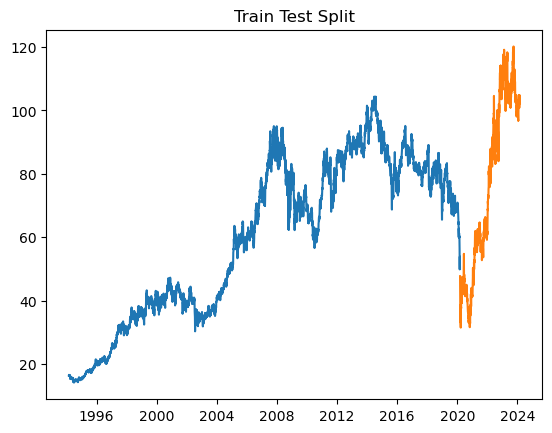

In [16]:
import matplotlib.pyplot as plt 
plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.title('Train Test Split');

In [17]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    abs_errors= np.abs(np.array(predicted) - np.array(y))
    min_abs_errors= np.min(abs_errors)
    max_abs_errors= np.max(abs_errors)
    med_abs_errors= np.median(abs_errors)
    mape = mean_absolute_percentage_error(y, predicted)

    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('minae: {:.2f}'.format(min_abs_errors))
    print('maxae: {:.2f}'.format(max_abs_errors))
    print('medae: {:.2f}'.format(med_abs_errors))
    print()

In [18]:
#predictors_1 = ["close", "volume", "open", "high", "low"]
predictors_2 = ["volume", "open", "high", "low"]

In [19]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors_2], train['close'])
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors_2], test['close'])





Performance of "RF Regressor" on Validation and Test set:
Test set:
****************
MAE: 1.85
MAPE: 0.02
minae: 0.00
maxae: 16.11
medae: 0.50

Performance of "xgboost" on Validation and Test set:
Test set:
****************
MAE: 1.97
MAPE: 0.02
minae: 0.00
maxae: 16.38
medae: 0.59

Performance of "Gradient Boost" on Validation and Test set:
Test set:
****************
MAE: 1.99
MAPE: 0.02
minae: 0.00
maxae: 16.59
medae: 0.60

Learning rate set to 0.358225
0:	learn: 16.4398693	total: 150ms	remaining: 14.8s
1:	learn: 11.0199521	total: 154ms	remaining: 7.55s
2:	learn: 7.3919245	total: 158ms	remaining: 5.11s
3:	learn: 4.9998495	total: 163ms	remaining: 3.9s
4:	learn: 3.4790224	total: 170ms	remaining: 3.23s
5:	learn: 2.5442193	total: 176ms	remaining: 2.76s
6:	learn: 2.0021105	total: 181ms	remaining: 2.4s
7:	learn: 1.6834262	total: 184ms	remaining: 2.12s
8:	learn: 1.4805802	total: 187ms	remaining: 1.89s
9:	learn: 1.3662121	total: 190ms	remaining: 1.71s
10:	learn: 1.2918315	total: 200ms	remaini

#### Retrain the best Model(Extreme Gradient Boosting)

In [20]:
model= GradientBoostingRegressor()
model.fit(train[predictors_2], train['close'])
pred= model.predict(test[predictors_2])

In [21]:

pred= pd.Series(pred, index=test.index)
combined_2= pd.concat([test['close'], pred],axis=1)

In [22]:
#combined_1.plot();
combined_2

,close,0
date,,
2020-03-06,47.689999,47.909292
2020-03-09,41.860001,43.293713
2020-03-10,43.410000,42.560758
2020-03-11,41.980000,42.911271
2020-03-12,37.180000,38.911888
...,...,...
2024-02-20,102.750000,103.289901
2024-02-21,104.849998,103.432996
2024-02-22,104.760002,103.353019


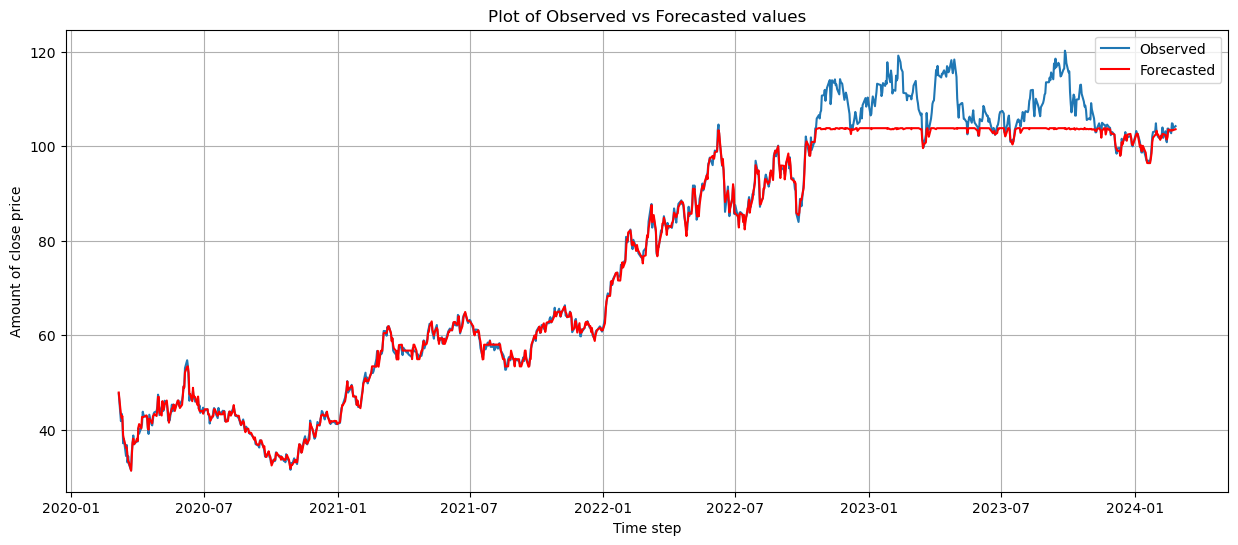

In [23]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_2['close'], label='Observed')
plt.plot(combined_2[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [24]:
#add additional predictors to the model
#calculate the mean close price in certain days and  find the ratio between today's closing price and that of the periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["close"] / rolling_averages["close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["close"]
    
    
    
    new_predictors+= [ratio_column, trend_column]

In [25]:
data['mom'] = data['close'].pct_change(12) # 12 month change

In [26]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [27]:
data['RSI']= computeRSI(data['close'], 14)

In [28]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,mom,RSI
date,,,,,,,,,,,,,,,,,,,
1994-02-28,16.34375,16.40625,16.21875,16.21875,3781600,16.21875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-01,16.15625,16.21875,16.09375,16.21875,4125600,16.46875,16.21875,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-02,16.15625,16.50000,16.12500,16.46875,5707600,16.53125,16.21875,1.007648,32.4375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-03,16.50000,16.59375,16.43750,16.53125,4846800,16.31250,16.46875,1.001894,32.6875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-04,16.50000,16.50000,16.28125,16.31250,2743200,16.31250,16.53125,0.993340,33.0000,0.997706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data.shape 

(7551, 19)

In [30]:
new_data=data[new_predictors]
new_data['close']=data['close']
new_data['MOM']=data['mom']
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM
date,,,,,,,,,,,,
1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.21875,NaN
1994-03-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.21875,NaN
1994-03-02,1.007648,32.4375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.46875,NaN
1994-03-03,1.001894,32.6875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.53125,NaN
1994-03-04,0.993340,33.0000,0.997706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.31250,NaN


In [31]:
new_data['SMA_3'] = new_data.iloc[:,10].rolling(window=3).mean()
new_data['SMA_4'] = new_data.iloc[:,10].rolling(window=4).mean()

In [32]:
new_data['CMA_4'] = new_data['close'].expanding(min_periods=4).mean()

In [33]:
new_data['EMA'] = new_data.iloc[:,10].ewm(span=40,adjust=False).mean()

In [34]:
new_data=new_data.dropna()
new_data.shape 

(6551, 16)

In [35]:
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM,SMA_3,SMA_4,CMA_4,EMA
date,,,,,,,,,,,,,,,,
1998-02-12,1.002982,62.37500,1.011225,155.34375,1.028682,1838.06250,1.053025,7480.31250,1.474536,21368.535156,31.53125,0.044513,31.302083,31.226562,21.378688,30.574720
1998-02-13,1.000495,62.87500,1.008588,155.90625,1.029369,1839.12500,1.053290,7485.87500,1.474939,21383.847656,31.56250,0.066526,31.479167,31.367188,21.388851,30.622905
1998-02-17,0.992016,63.09375,0.992214,156.46875,1.013080,1839.71875,1.035878,7491.40625,1.450584,21399.191406,31.06250,0.022634,31.385417,31.375000,21.398496,30.644348
1998-02-18,1.013400,62.62500,1.013500,156.53125,1.040103,1839.68750,1.063147,7496.65625,1.488917,21413.785156,31.90625,0.075869,31.510417,31.515625,21.408962,30.705905
1998-02-19,0.998529,62.96875,1.007522,157.40625,1.036783,1840.56250,1.059194,7502.78125,1.483470,21429.160156,31.81250,0.051653,31.593750,31.585938,21.419314,30.759885


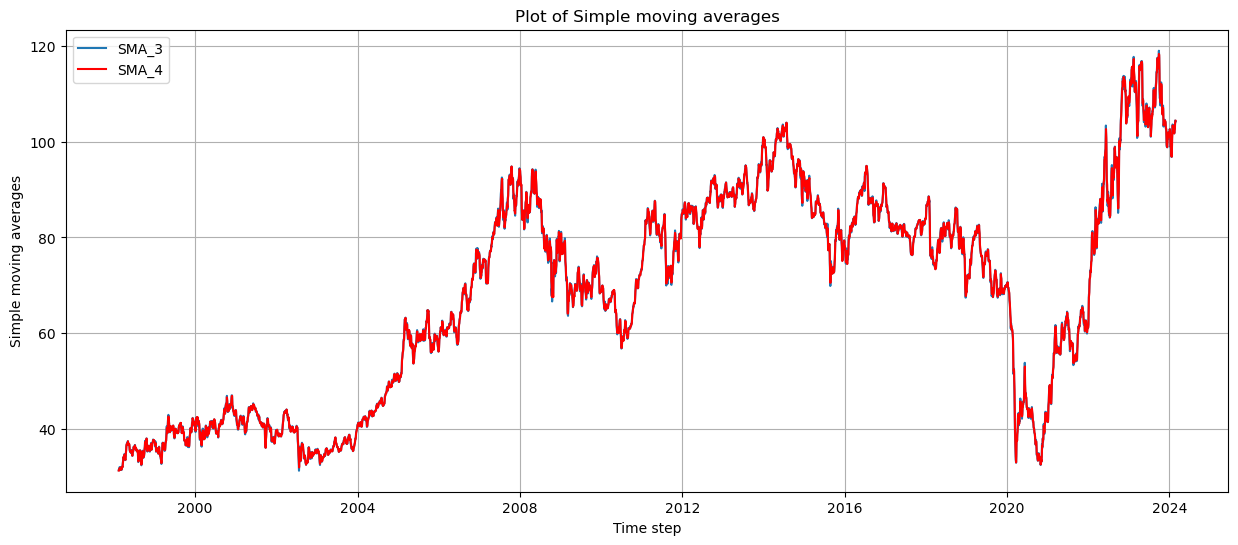

In [36]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['SMA_3'], label='SMA_3')
plt.plot(new_data['SMA_4'], color='r', label='SMA_4')
plt.title('Plot of Simple moving averages')
plt.ylabel('Simple moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

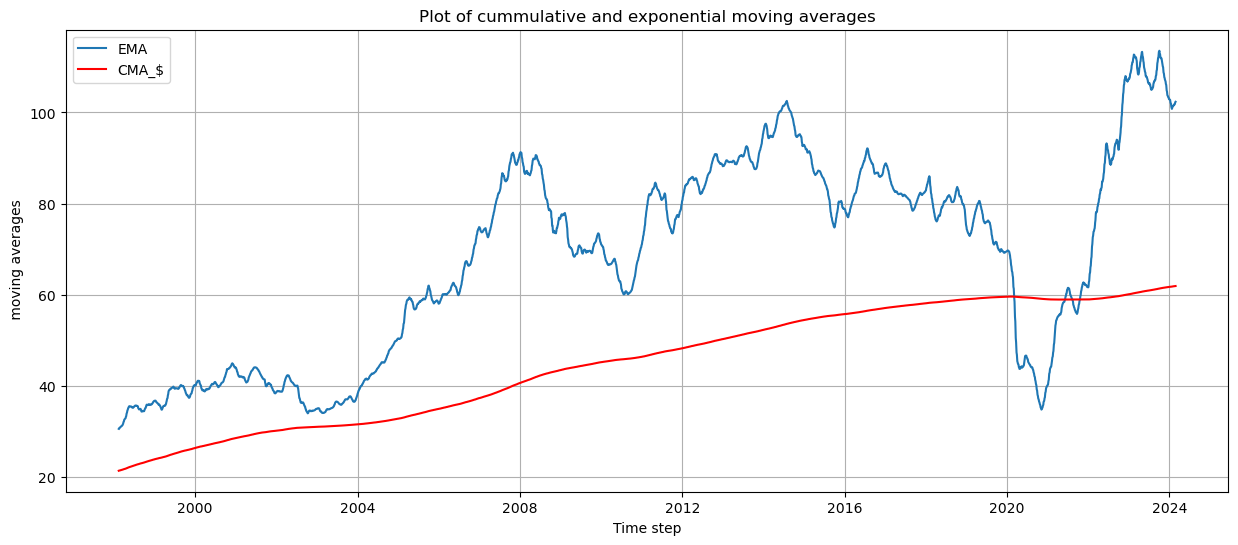

In [37]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['EMA'], label='EMA')
plt.plot(new_data['CMA_4'], color='r', label='CMA_$')
plt.title('Plot of cummulative and exponential moving averages')
plt.ylabel(' moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

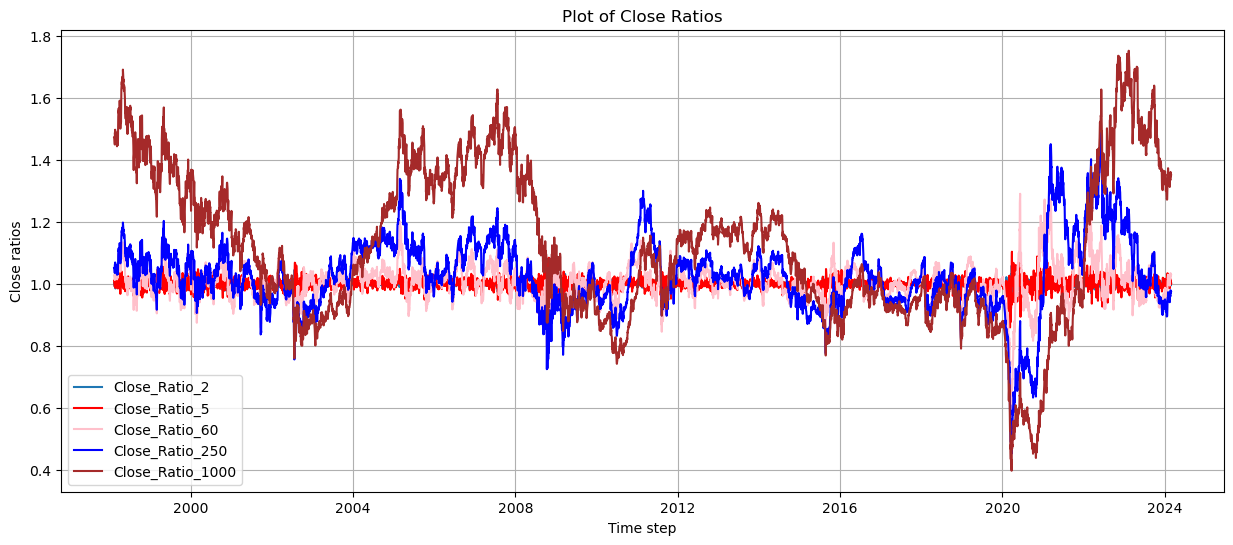

In [38]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Close_Ratio_2'], label='Close_Ratio_2')
plt.plot(new_data['Close_Ratio_5'], color='r', label='Close_Ratio_5')
plt.plot(new_data['Close_Ratio_60'], color='pink', label='Close_Ratio_60')
plt.plot(new_data['Close_Ratio_250'], color='b', label='Close_Ratio_250')
plt.plot(new_data['Close_Ratio_1000'], color='brown', label='Close_Ratio_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

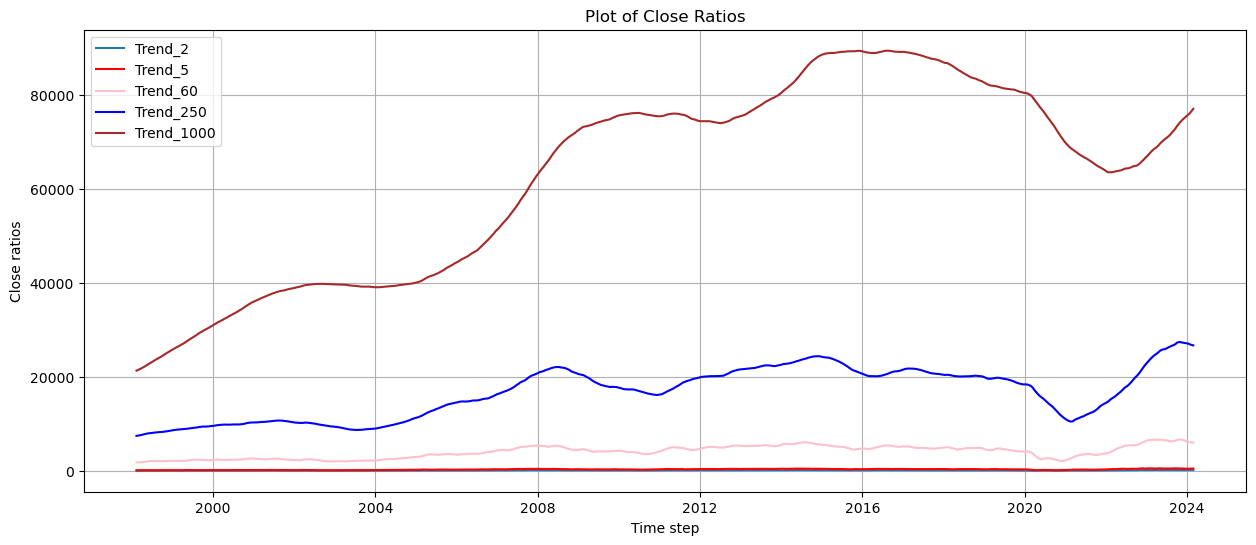

In [39]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Trend_2'], label='Trend_2')
plt.plot(new_data['Trend_5'], color='r', label='Trend_5')
plt.plot(new_data['Trend_60'], color='pink', label='Trend_60')
plt.plot(new_data['Trend_250'], color='b', label='Trend_250')
plt.plot(new_data['Trend_1000'], color='brown', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [40]:
new_data['RSI']=data['RSI']
new_data['previousday']=data['previousday']

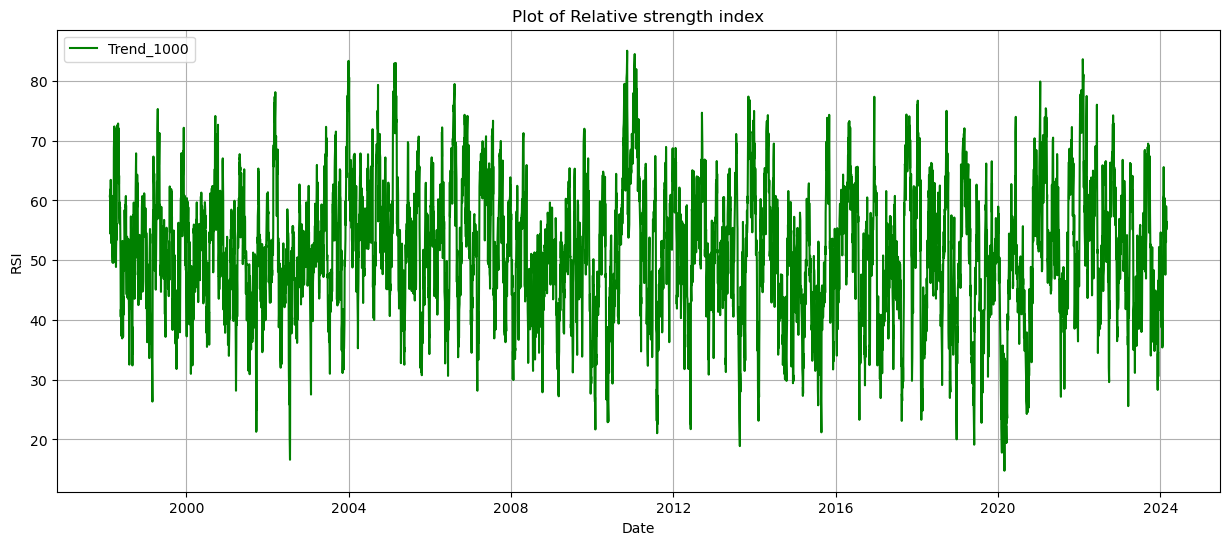

In [41]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['RSI'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Relative strength index')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

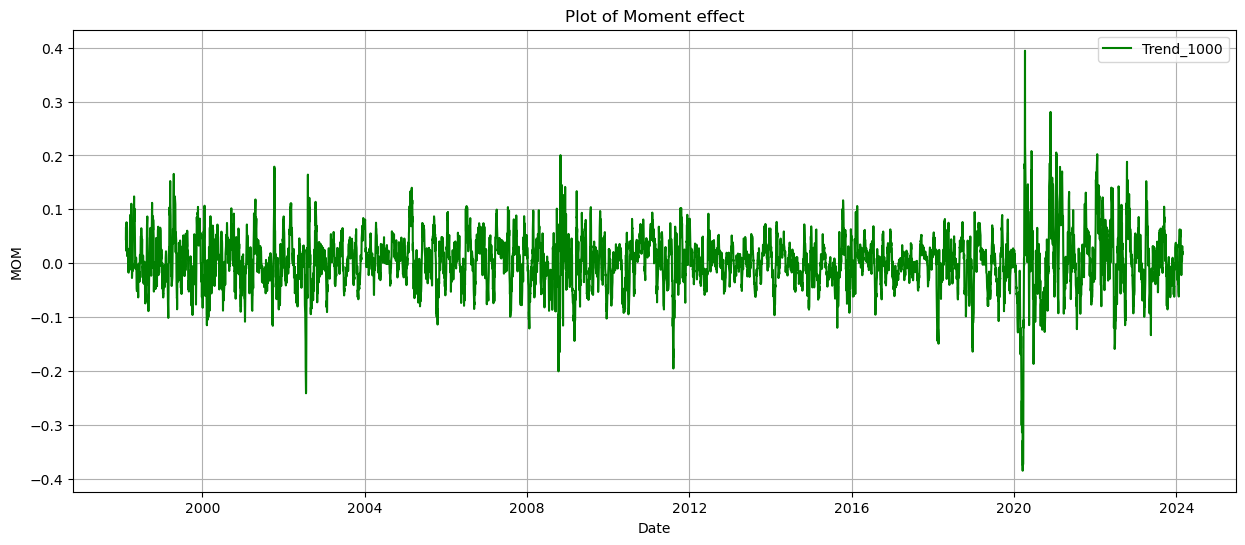

In [42]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['MOM'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Moment effect')
plt.ylabel('MOM')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [43]:
train = new_data.iloc[:-1000]
test = new_data.iloc[-1000:]

In [44]:
train.shape

(5551, 18)

In [45]:
new_data.columns

Index(['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'close', 'MOM', 'SMA_3', 'SMA_4',
       'CMA_4', 'EMA', 'RSI', 'previousday'],
      dtype='object')

In [46]:
predictors= ['SMA_3','SMA_4','EMA','RSI','MOM', 'previousday'] 

#### Retrain the models on the new predictors

In [47]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors], train['close'])
    print(f'Performance of "{key}" on  Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors], test['close'])

Performance of "RF Regressor" on  Test set:
Test set:
****************
MAE: 2.23
MAPE: 0.02
minae: 0.01
maxae: 16.01
medae: 0.86

Performance of "xgboost" on  Test set:
Test set:
****************
MAE: 2.46
MAPE: 0.03
minae: 0.00
maxae: 16.57
medae: 0.89

Performance of "Gradient Boost" on  Test set:
Test set:
****************
MAE: 2.45
MAPE: 0.03
minae: 0.00
maxae: 16.68
medae: 0.94

Learning rate set to 0.348972
0:	learn: 13.7045613	total: 4.09ms	remaining: 405ms
1:	learn: 9.3320803	total: 7.2ms	remaining: 353ms
2:	learn: 6.3726386	total: 10ms	remaining: 324ms
3:	learn: 4.4623221	total: 13ms	remaining: 311ms
4:	learn: 3.2099596	total: 16.9ms	remaining: 322ms
5:	learn: 2.4385920	total: 20.5ms	remaining: 321ms
6:	learn: 1.9911383	total: 23.5ms	remaining: 312ms
7:	learn: 1.7092930	total: 26.4ms	remaining: 304ms
8:	learn: 1.4931880	total: 29.3ms	remaining: 297ms
9:	learn: 1.3911600	total: 32.2ms	remaining: 290ms
10:	learn: 1.2932872	total: 35.8ms	remaining: 290ms
11:	learn: 1.2380234	tota

#### Improving the model

In [48]:
#model_1 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
#n_estimators=200, min_samples_split=50, random_state=1
model_2= GradientBoostingRegressor(random_state=0)

def predict(train, test, predictors_1, model_1):
    model_1.fit(train[predictors_1], train["Target"])
    preds_1 = model_1.predict_proba(test[predictors_1])[:,1]
    preds_1[preds_1 >=.6] = 1
    preds_1[preds_1 <.6] = 0
    preds_1 = pd.Series(preds_1, index=test.index, name="Predictions_1")
    combined_1 = pd.concat([test["Target"], preds_1], axis=1)
    return combined_1 

In [49]:
def predict(train, test, predictors, model_2):
    model_2.fit(train[predictors], train["close"])
    preds_2 = model_2.predict(test[predictors])
    preds_2 = pd.Series(preds_2, index=test.index, name="Predictions_2")
    combined_2 = pd.concat([test["close"], preds_2], axis=1)
    return combined_2

In [50]:
def backtest(new_data, model_2, predictors, start=1500, step=250):
    all_predictions = []

    for i in range(start, new_data.shape[0], step):
        train = new_data.iloc[0:i].copy()
        test = new_data.iloc[i:(i+step)].copy()
        predictions_2 = predict(train, test, predictors, model_2)
        all_predictions.append(predictions_2)
    
    return pd.concat(all_predictions)

In [51]:
predictions_2 = backtest(new_data, model_2, predictors)

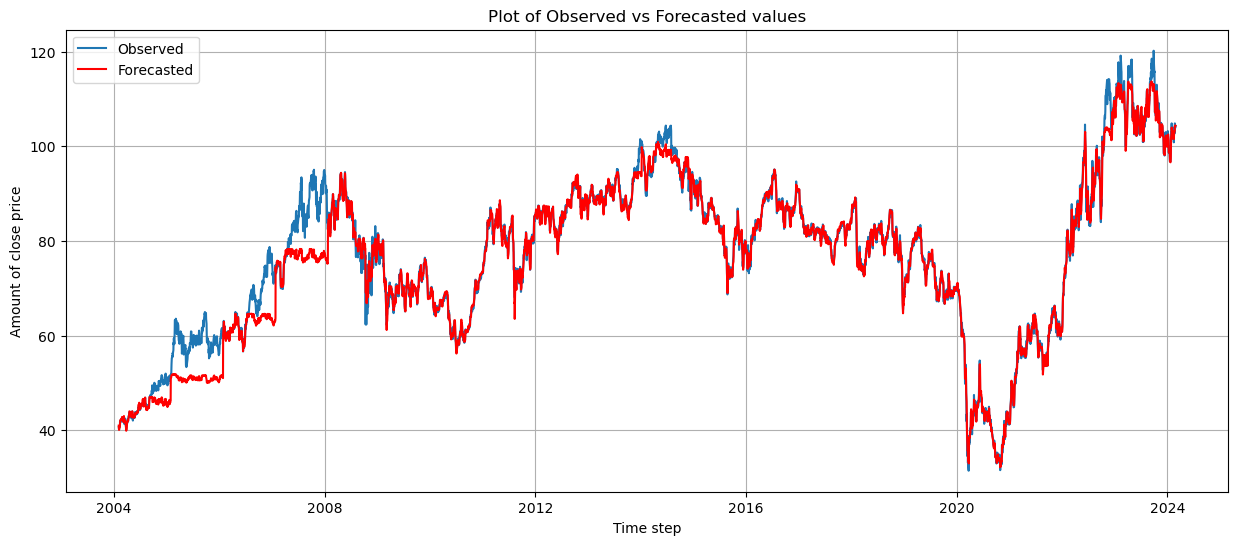

In [52]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(predictions_2['close'], label='Observed')
plt.plot(predictions_2['Predictions_2'], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [53]:
model_2.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [54]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [55]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.03465727050755825

mean absolute  error is : 2.9271441718372913



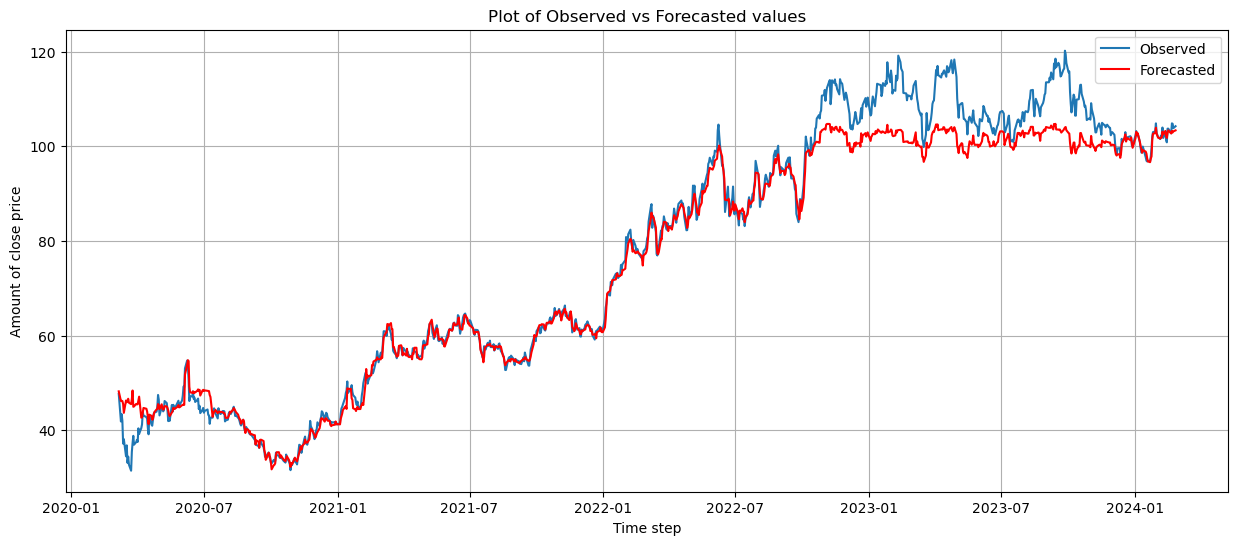

In [56]:
# Plot the test predictions and true values
pred= pd.Series(prediction, index=test.index)
plt.figure(figsize=(15,6))
plt.plot(test['close'], label='Observed')
plt.plot(pred, color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

#### Perform Hyper parameter tuning using grid searchcv

#possibe hyperparameters for random forest
hyper = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 6]
}

from sklearn.model_selection import GridSearchCV

cv_model= GridSearchCV(GradientBoostingRegressor(), param_grid=hyper)
cv_model.fit(train[predictors], train['close'])

print(cv_model.best_score_)
print(cv_model.best_estimator_)

In [57]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, min_samples_split=5)
model.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [58]:
grdb_mae =  mean_absolute_error(test['close'], prediction)
abs_errors= np.abs(np.array(prediction) - np.array(test['close']))
grdb_min_abs_errors= np.min(abs_errors)
grdb_max_abs_errors= np.max(abs_errors)
grdb_med_abs_errors= np.median(abs_errors)
grdb_mape = mean_absolute_percentage_error(test['close'], prediction)

In [59]:
print(f"Optimized Gradient boosting Performance Metrics \n\n \
gradientboost Mae: {grdb_mae} \n \
gradientboost minae: {grdb_min_abs_errors} \n \
gradientboost maxae: {grdb_max_abs_errors} \n \
gradientboost medae: {grdb_med_abs_errors} \n \
gradientboost Mape: {grdb_mape} \n \
 \n\n <-------------------------------------------------->\n")

Optimized Gradient boosting Performance Metrics 

 gradientboost Mae: 2.365401697156848 
 gradientboost minae: 0.007334318717539645 
 gradientboost maxae: 16.028752144108324 
 gradientboost medae: 0.9045605207885288 
 gradientboost Mape: 0.02598307370325245 
  

 <-------------------------------------------------->



In [60]:
pred= pd.Series(prediction, index=test.index)
combined= pd.concat([test['close'], pred],axis=1)
combined 

,close,0
date,,
2020-03-06,47.689999,49.112671
2020-03-09,41.860001,46.968405
2020-03-10,43.410000,44.777981
2020-03-11,41.980000,43.780001
2020-03-12,37.180000,42.347868
...,...,...
2024-02-20,102.750000,102.945412
2024-02-21,104.849998,103.856533
2024-02-22,104.760002,103.980573


In [61]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [62]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.02598307370325245

mean absolute  error is : 2.365401697156848



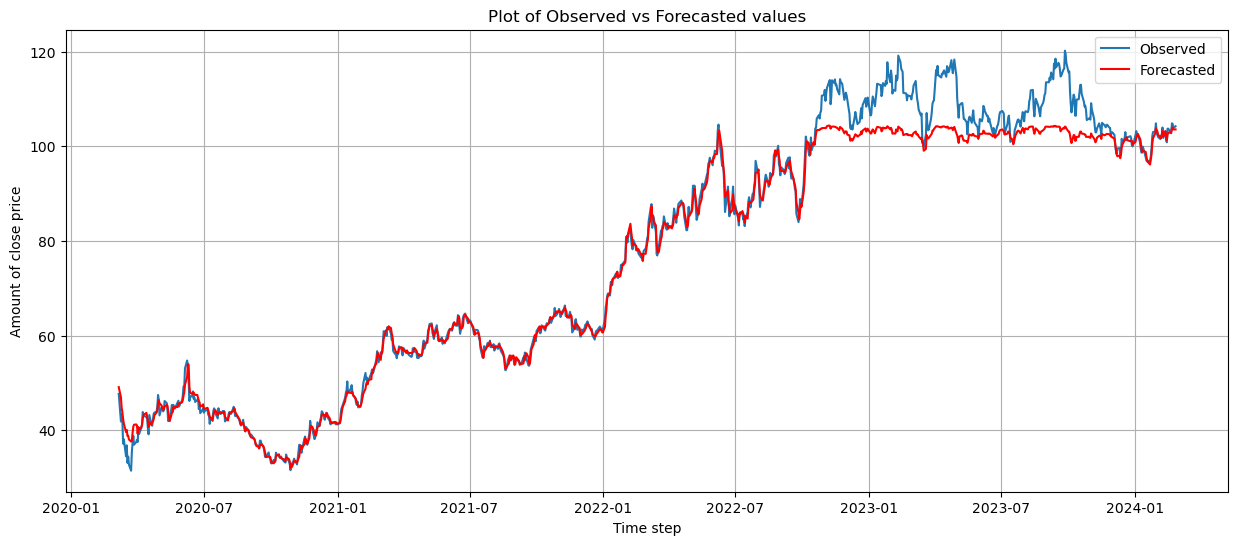

In [63]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined['close'], label='Observed')
plt.plot(combined[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

### Stacking and Bagging

In [64]:
# List of machine learning algorithms to consider
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet 
algorithms = [
    ('Linear regression', LinearRegression(), {}),
    ('Ridge', Ridge(), {}),
    ('Lasso', Lasso(), {}),
    ('Elastic Net', ElasticNet(), {}),
    #('SVM', SVC(kernel='linear', probability=True, decision_function_shape='ovr'), {}),
    ('MLP', MLPRegressor(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(train[predictors], train['close'])
    base_models[algorithm_name] = model

eval_metrics = ['mae', 'mape']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(test[predictors])
    mae= mean_absolute_error(test['close'], y_pred)
    mape =mean_absolute_percentage_error(test['close'], y_pred)

# Ensembling using Bagging with all base models
bagging_model = BaggingRegressor(base_estimator=None, n_estimators=10, random_state=42)
bagging_model.fit(train[predictors], train['close'])
bagging_y_pred = bagging_model.predict(test[predictors])
bagging_mae = mean_absolute_error(test['close'], bagging_y_pred)
abs_errors= np.abs(np.array(bagging_y_pred) - np.array(test['close']))
bagg_min_abs_errors= np.min(abs_errors)
bagg_max_abs_errors= np.max(abs_errors)
bagg_med_abs_errors= np.median(abs_errors)
bagging_mape = mean_absolute_percentage_error(test['close'], bagging_y_pred)
print(f"Bagging Ensemble Method Performance Metrics \n\n \
bagging Mae: {bagging_mae} \n \
bagging minae: {bagg_min_abs_errors} \n \
bagging maxae: {bagg_max_abs_errors} \n \
bagging medae: {bagg_med_abs_errors} \n \
bagging Mape: {bagging_mape} \n \
 \n\n <-------------------------------------------------->\n")

# Ensembling using Stacking
meta_model = Ridge()
stacking_model = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(train[predictors], train['close'])
stacking_y_pred = stacking_model.predict(test[predictors])
stacking_mae =  mean_absolute_error(test['close'], stacking_y_pred)
abs_errors= np.abs(np.array(stacking_y_pred) - np.array(test['close']))
stack_min_abs_errors= np.min(abs_errors)
stack_max_abs_errors= np.max(abs_errors)
stack_med_abs_errors= np.median(abs_errors)
stacking_mape = mean_absolute_percentage_error(test['close'], stacking_y_pred)
print(f"Stacking Ensemble Method Performance Metrics \n\n \
stacking mae: {stacking_mae} \n \
stacking minae: {stack_min_abs_errors} \n \
stacking maxae: {stack_max_abs_errors} \n \
stacking medae: {stack_med_abs_errors} \n \
stacking mape: {stacking_mape} \n")




#print(f"Stacking F1 Score: {stacking_f1}")


LinearRegression()
Ridge()
Lasso()
ElasticNet()
MLPRegressor()
Bagging Ensemble Method Performance Metrics 

 bagging Mae: 2.2276102739000017 
 bagging minae: 9.00000017622915e-07 
 bagging maxae: 16.087995800000016 
 bagging medae: 0.8946879999999986 
 bagging Mape: 0.024467750631217533 
  

 <-------------------------------------------------->

Stacking Ensemble Method Performance Metrics 

 stacking mae: 0.7090018906057118 
 stacking minae: 0.0010909338799223178 
 stacking maxae: 4.354579674588642 
 stacking medae: 0.5209631512423805 
 stacking mape: 0.009904524504222714 



In [65]:
bagging_y_pred= pd.Series(bagging_y_pred, index=test.index)
stacking_y_pred= pd.Series(stacking_y_pred, index=test.index)

In [66]:
combined_stack= pd.concat([test['close'], stacking_y_pred],axis=1)
combined_bagg= pd.concat([test['close'], bagging_y_pred], axis=1)

In [67]:
combined_bagg.head()

,close,0
date,,
2020-03-06,47.689999,49.961000
2020-03-09,41.860001,47.607001
2020-03-10,43.410000,44.870750
2020-03-11,41.980000,43.302000
2020-03-12,37.180000,41.821375


In [68]:
combined_stack

,close,0
date,,
2020-03-06,47.689999,50.345331
2020-03-09,41.860001,45.610819
2020-03-10,43.410000,45.805572
2020-03-11,41.980000,42.669012
2020-03-12,37.180000,41.534580
...,...,...
2024-02-20,102.750000,103.361034
2024-02-21,104.849998,104.273627
2024-02-22,104.760002,103.816084


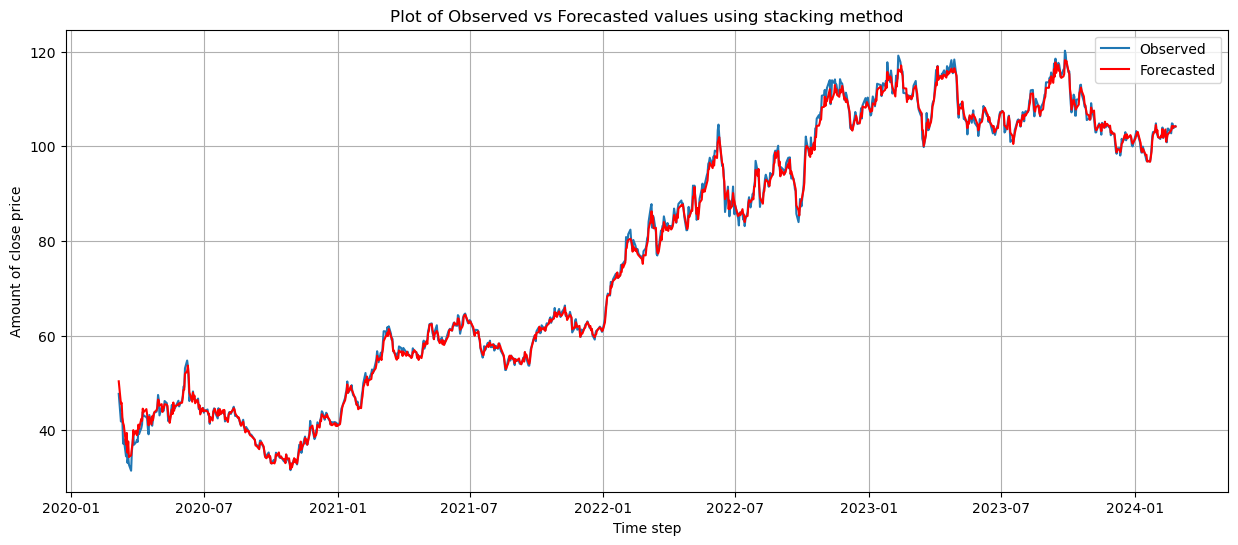

In [69]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_stack['close'], label='Observed')
plt.plot(combined_stack[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

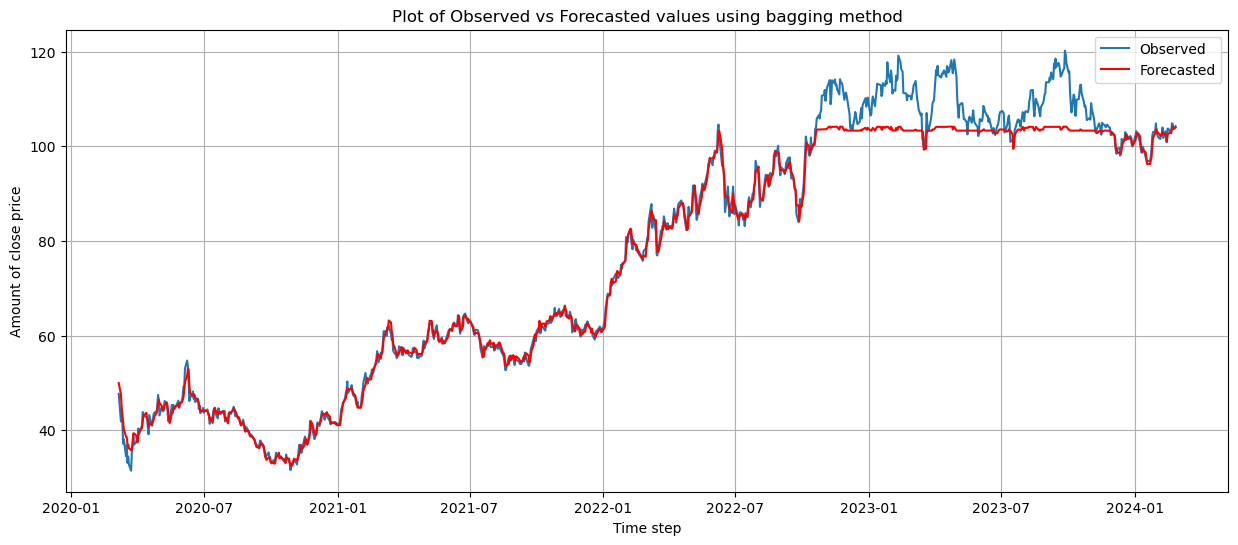

In [70]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

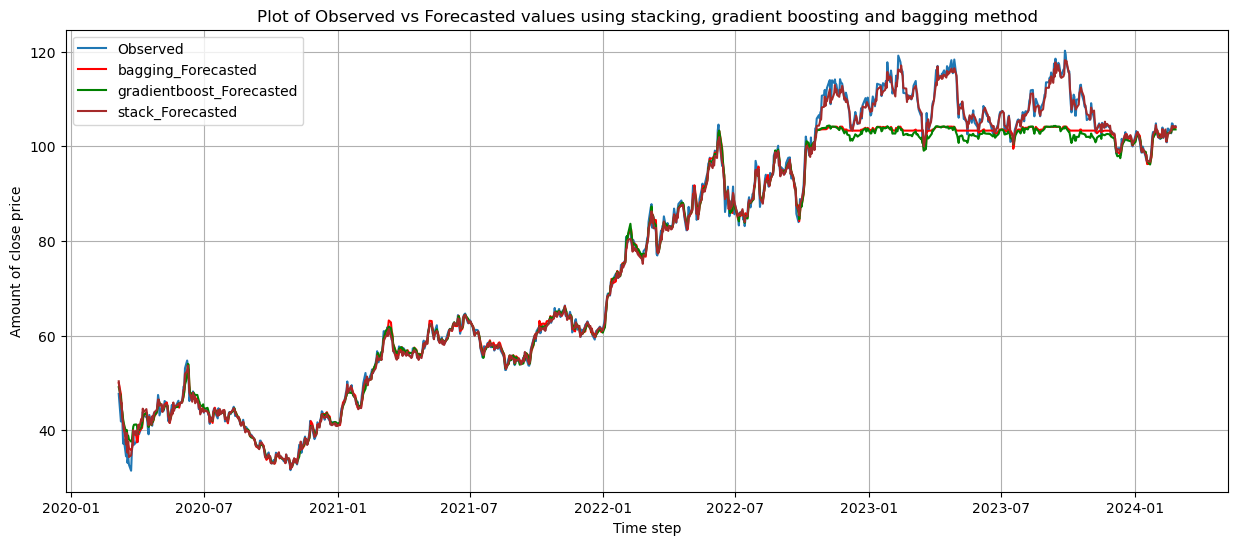

In [71]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='bagging_Forecasted')
plt.plot(combined[0], color='green', label='gradientboost_Forecasted')
plt.plot(combined_stack[0], color='brown', label='stack_Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking, gradient boosting and bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('Exxonmobilresult.png')
plt.show()

In [72]:
from prettytable import PrettyTable
import joblib
import os
# Constructing the result summary table containing the scores for each model on  test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on Test","MAPE on Test", "MinAE on Test", "MaxAE on Test", "MedAE on Test"]
task1_result.add_row(['RF Reg', 2.23, 0.02, 0.01, 16.01, 0.86])
task1_result.add_row(['XGboost', 2.46, 0.03, 0.00, 16.57, 0.89])
task1_result.add_row(['GradientBoost', 2.45, 0.03, 0.00, 16.68, 0.94])
task1_result.add_row(['Catboost', 2.93, 0.03, 0.00, 16.23, 1.14])
task1_result.add_row(['Bagging', 2.23, 0.02, 9.00, 16.09, 0.90])
task1_result.add_row(['Stacking', 0.71, 0.01, 0.00, 4.25, 0.53])

print('Result Summary for All Regressors :')
print(task1_result)


Result Summary for All Regressors :
+---------------+-------------+--------------+---------------+---------------+---------------+
|   Regressor   | MAE on Test | MAPE on Test | MinAE on Test | MaxAE on Test | MedAE on Test |
+---------------+-------------+--------------+---------------+---------------+---------------+
|     RF Reg    |     2.23    |     0.02     |      0.01     |     16.01     |      0.86     |
|    XGboost    |     2.46    |     0.03     |      0.0      |     16.57     |      0.89     |
| GradientBoost |     2.45    |     0.03     |      0.0      |     16.68     |      0.94     |
|    Catboost   |     2.93    |     0.03     |      0.0      |     16.23     |      1.14     |
|    Bagging    |     2.23    |     0.02     |      9.0      |     16.09     |      0.9      |
|    Stacking   |     0.71    |     0.01     |      0.0      |      4.25     |      0.53     |
+---------------+-------------+--------------+---------------+---------------+---------------+
